# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [244]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sms
import matplotlib.pyplot as plt
import plotly.express as px

### Consolidar Base de Dados

In [188]:
meses = {'jan': 1, 'fev': 2,'mar': 3,'abr': 4,'mai': 5,'jun': 6,'jul': 7,'ago': 8,'set': 9,'out': 10,'nov': 11,'dez': 12,}

caminho_bases = pathlib.Path('dataset')
base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    #df = pd.read_csv(r'dataset\{}'.format(arquivo.name))
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:] #ultimos 8 caracteres
    ano = int(ano.replace('.csv', '')) #trocar com espaço vaz
    
    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes    
    base_airbnb = base_airbnb.append(df)

display(base_airbnb)

#abril2018_df = pd.read_csv(r'dataset\abril2018.csv')
#display(abril2018_df)

C:\Users\gleisson.santos\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (62,87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\gleisson.santos\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (61,62,94) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\gleisson.santos\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [189]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registro.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [190]:
#utilizando : ="'"&B1&"'" /  =UNIRTEXTO(",";FALSO;B2:AI2)
colunas = ['host_response_time','host_response_rate','host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes'
]

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

In [191]:
print(base_airbnb['host_response_rate'].value_counts()) #quantidade de intens em uma coluna

100%    297308
0%       31796
90%      22374
80%      14899
50%      14515
         ...  
16%         11
3%          10
7%          10
5%           4
4%           3
Name: host_response_rate, Length: 98, dtype: int64


In [192]:
print((base_airbnb['host_listings_count']== base_airbnb['host_total_listings_count']).value_counts())


KeyError: 'host_total_listings_count'

In [193]:
print(base_airbnb['square_feet'].isnull().sum()) #soma todos os dados vazios de uma coluna

KeyError: 'square_feet'

### Tratar Valores Faltando

 - Analisando os dados, percebi que possui uma grande disparidade de dados faltantes. As colunas com mais de 300mil valores NAN foram exluidas da analise.
 - Para as outras colunas, como temos muitos dados (mais de 900mil linhas), vamos excluir as linhas que contém dados NAN

In [194]:
#analisando e exclusão de  colunas com valores NAN

for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1) #excluir colunas que possuem menos de 3mil itens
        
print(base_airbnb.isnull().sum())


host_is_superhost            460
host_listings_count          460
latitude                       0
longitude                      0
property_type                  0
room_type                      0
accommodates                   0
bathrooms                   1724
bedrooms                     850
beds                        2502
bed_type                       0
amenities                      0
price                          0
guests_included                0
extra_people                   0
minimum_nights                 0
maximum_nights                 0
number_of_reviews              0
instant_bookable               0
is_business_travel_ready       0
cancellation_policy            0
ano                            0
mes                            0
dtype: int64


In [195]:
#retirar os NAN com o Dropna()
print('Como NAN', base_airbnb.shape) #qtd de colunas e linhas

base_airbnb = base_airbnb.dropna()

print('Sem NAN', base_airbnb.shape) #qtd de colunas e linhas

print(base_airbnb.isnull().sum())

Como NAN (902210, 23)
Sem NAN (897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [196]:
print(base_airbnb.dtypes)
print('-' * 30)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------
host_is_superhost                                                           f
host_listings_count                              

- Como as colunas price extra_people estão sendo reconhecidos como objeto ao inves do float, devemos mudar o tipo da coluna

In [197]:
#price
#extra_people
#manter apenas o ponto decimal

base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '')
#np - numpy, trata numeros, serie de dados
#quando tiver uma tabela com muita inf. para converter usar o float 32
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)


base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '')
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

#verificando os tipos
print(base_airbnb.dtypes)


C:\Users\GLEISS~1.SAN\AppData\Local\Temp/ipykernel_15396/2202197039.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['price'] = base_airbnb['price'].str.replace('$', '')
C:\Users\GLEISS~1.SAN\AppData\Local\Temp/ipykernel_15396/2202197039.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '')


host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

<AxesSubplot:>

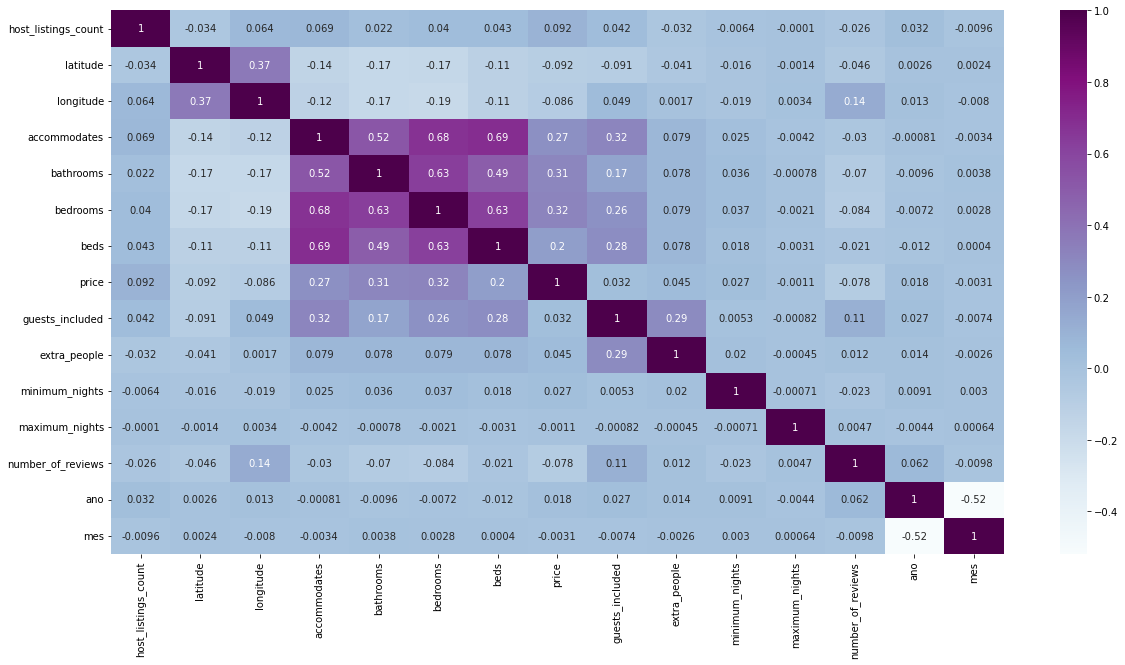

In [198]:
#Analise de Correlação entre as colunas

#print(base_airbnb.corr())
plt.figure(figsize=(20,10))
sms.heatmap(base_airbnb.corr(), annot=True, cmap = 'BuPu' )


Definição de funções para Analise de Outliers

 - Vamos definir algumas funções para ajudar na analise de Outliers das colunas

In [199]:
#me retorna uma tupla com o limite inferior e superior
def limites(coluna):
    q1 = coluna.quantile(0.25) #quantile passa a posição do quartil
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1 
    #return limite_inferior, limite_superior
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

#Vai receber um DataFrame e exluir ou Outliers e contar qts colunas excluiu
def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0] #shap informa a qtd de linhas e colunas
    lim_inf, lim_sup = limites(df[nome_coluna])
    #filtrar as linhas onde os valores atendem a compração:
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas
    

In [200]:
'''
count    897709.000000 - Quantos valores tem na coluna
mean        648.062195 - media dos valores 
std        1705.104980 - desvio padrão dos valores
min           0.000000 - menor valor
25%         151.000000 - 1º Quartil
50%         297.000000 - 2º Quartil - Mediana
75%         601.000000 - 3º Quartil
max      138288.000000 - maior valor
'''
print(limites(base_airbnb['price']))
base_airbnb['price'].describe()
print(601 + 1.5 * (601 - 151)) # Calculo limite superior

(-524.0, 1276.0)
1276.0


In [201]:
#para dois graficos ou mais
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2) # 1 linha, 2 colunas
    fig.set_size_inches(15,5) #tamanho do grafico
    sms.boxplot(x=coluna, ax=ax1) 
    ax2.set_xlim(limites(coluna)) #setar o limite/zoom do grafico inferior e superior
    sms.boxplot(x=coluna, ax=ax2)
    
#para um grafico
def histograma(coluna):
    plt.figure(figsize=(15,5))
    sms.distplot(coluna, ) #histplot substituiu o distplot
    
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sms.barplot(x=coluna.value_counts().index , y=coluna.value_counts() )
    ax.set_xlim(limites(coluna))  #setar o limite/zoom do grafico inferior e superior
    

### Preço


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


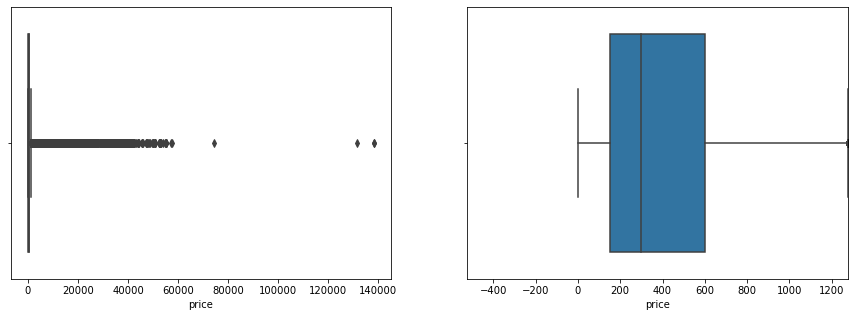

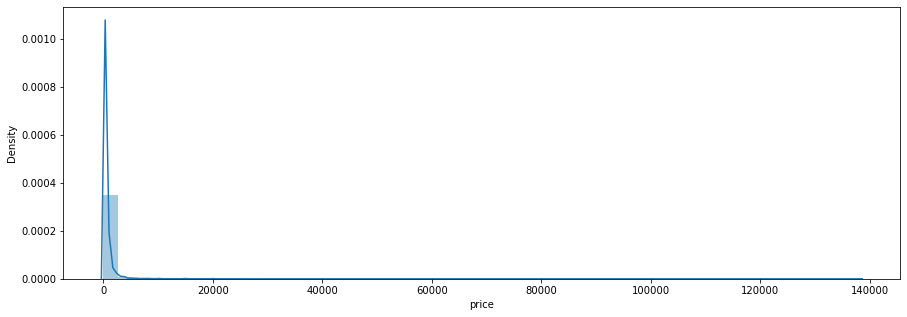

In [202]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

 - Como estamos construindo um modelo para imoveis comuns,acredito que os valores acima do limite superior serão apenas apartamento de altissimo luxo, que não é do nosso objetivo principal. Por isso, podemos exluir esses outliers

In [203]:
#remover iten para não prever dados com imoveis de alto nivel/padrão
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


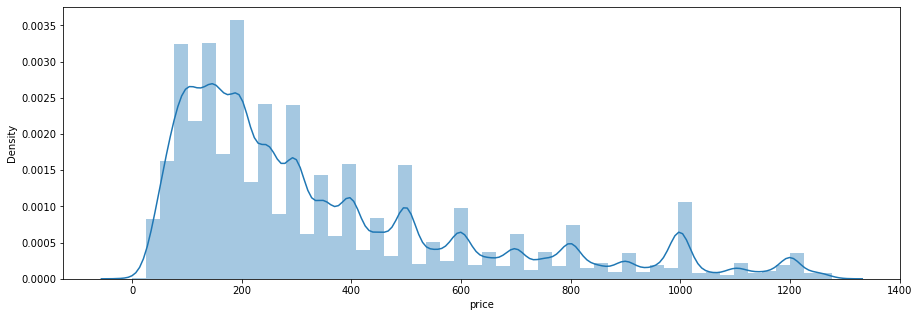

In [204]:
histograma(base_airbnb['price'])

### EXTRA PEOPLE

C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


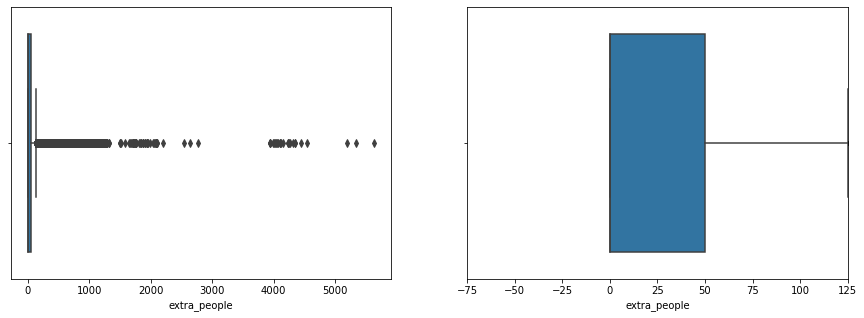

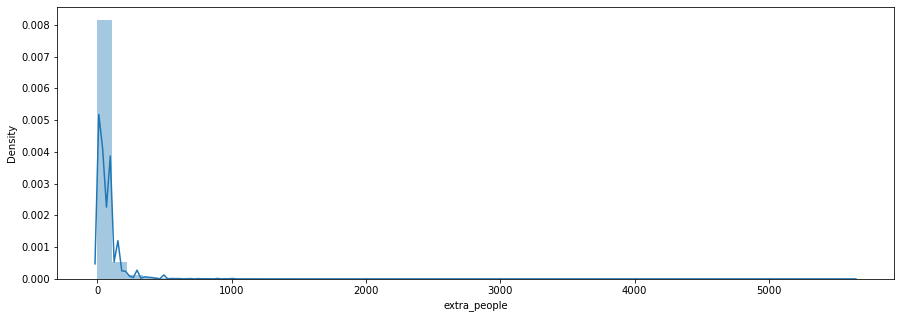

In [205]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [206]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


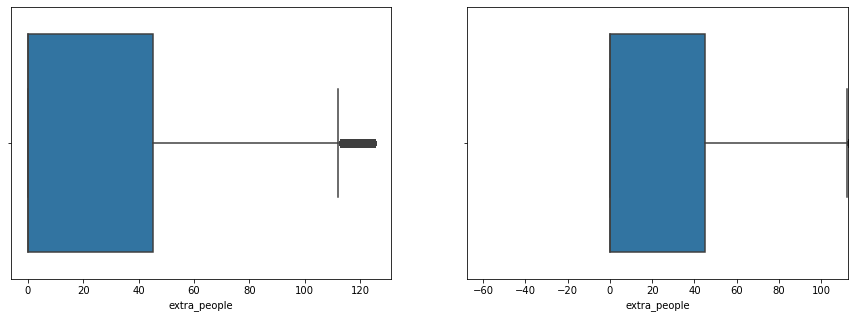

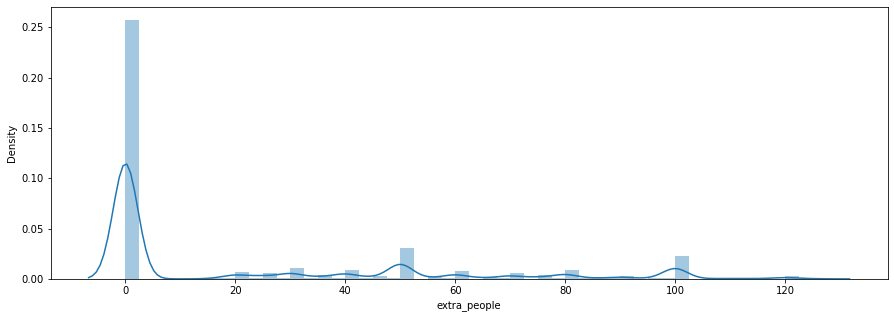

In [207]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

### host_listings_count

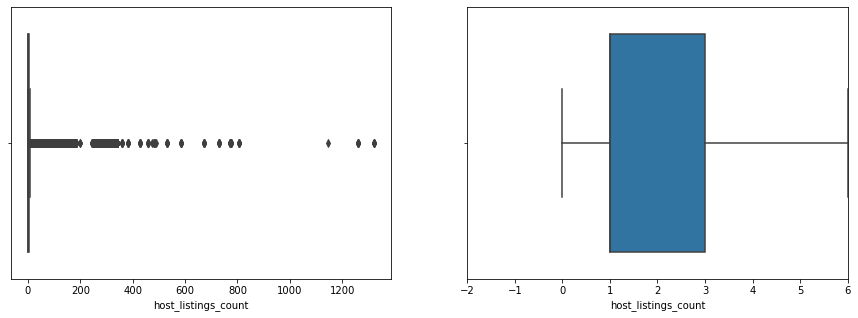

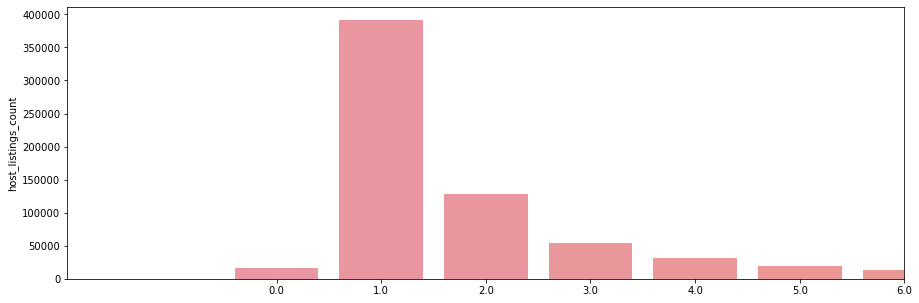

In [208]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

 - Podemos exluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imoveis no airbnb não é o publico alvo do objetivo do projeto ('imagino que sejam imobiliarias ou profissionais gerenciando pelo airbnb')

In [209]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


### accommodates

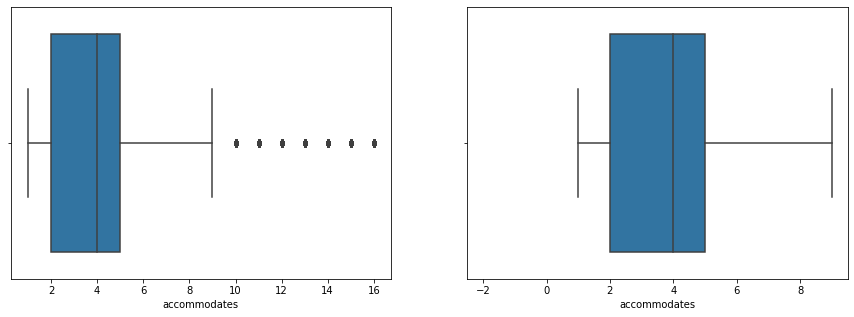

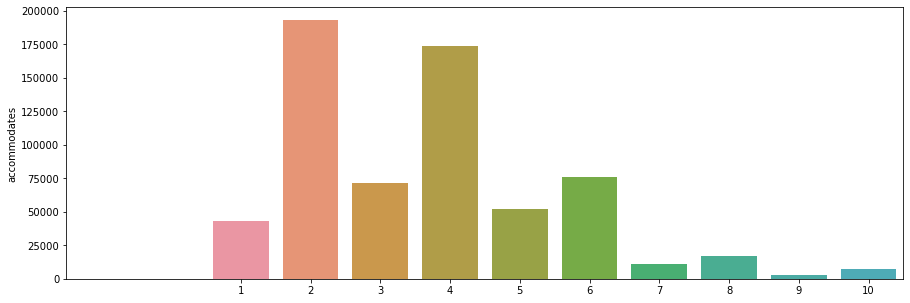

In [210]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [211]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms

<AxesSubplot:ylabel='bathrooms'>

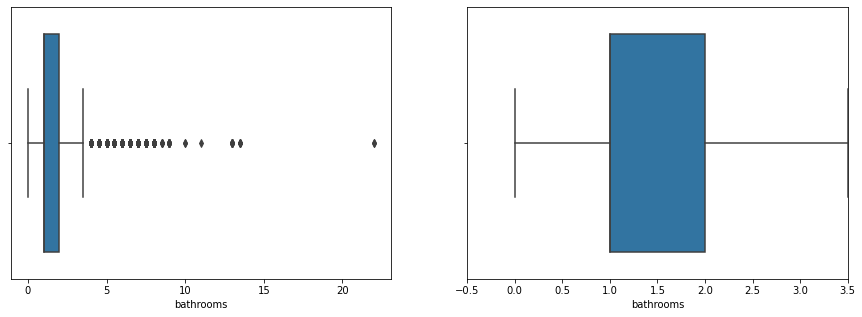

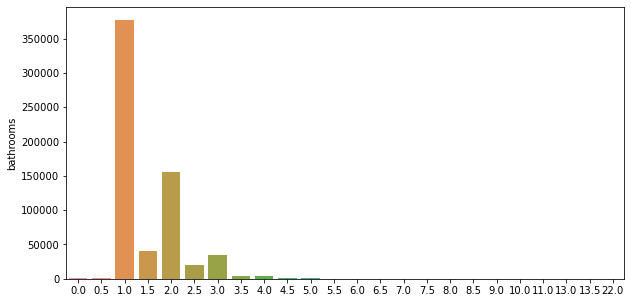

In [212]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(10,5))
sms.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [213]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

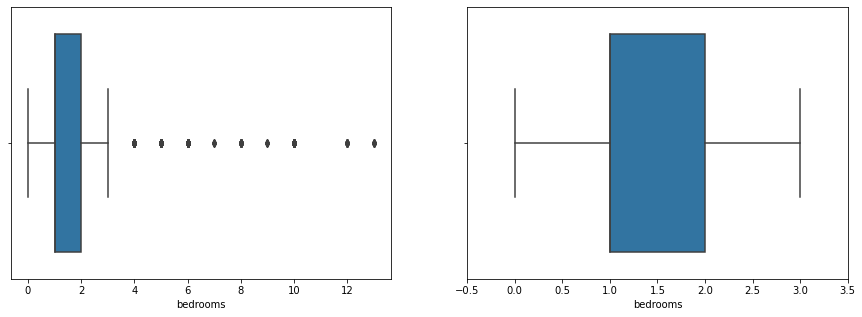

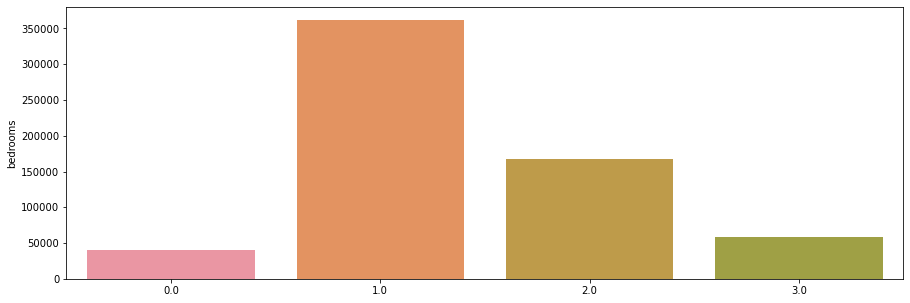

In [214]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [215]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

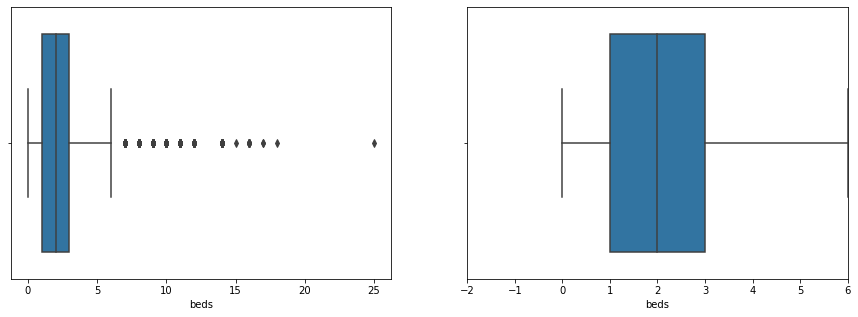

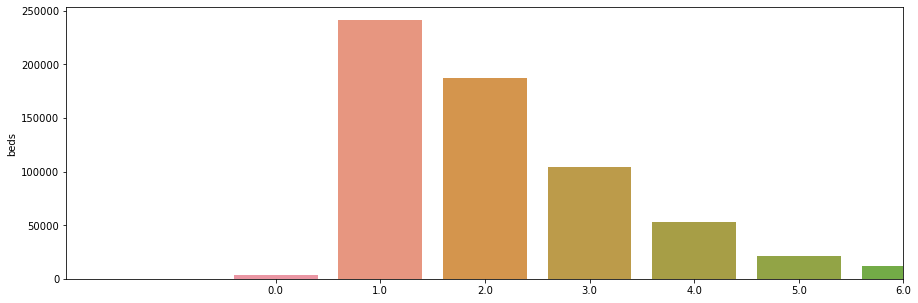

In [216]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [217]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

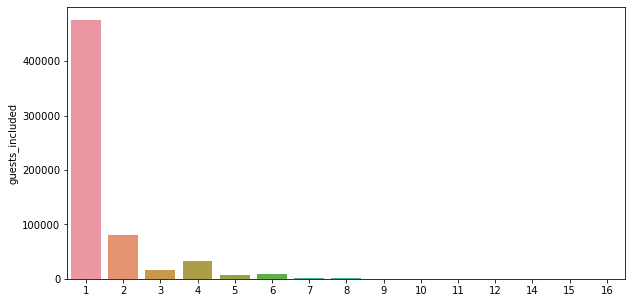

In [218]:
#Qtd de imoveis a pessoa tem
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])

print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(10,5))
sms.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature dessa analise. Parece que o cadastro da airbn usam o valor padrão como um guests_included. Isso pode prejudicar a analise do modelo para a definição do preço. por isso estaremos de forma mais eficaz, excluir a coluna da analise

In [219]:
#excluir coluna que não servirar para analise
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights

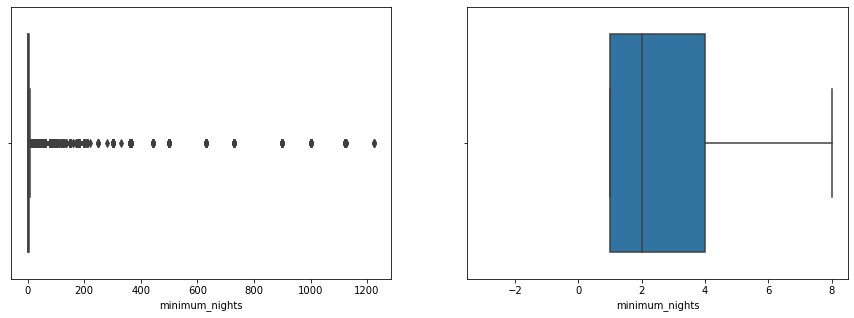

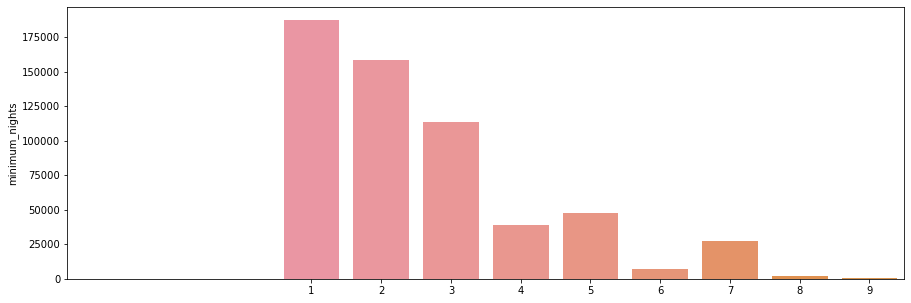

In [220]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [221]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights  

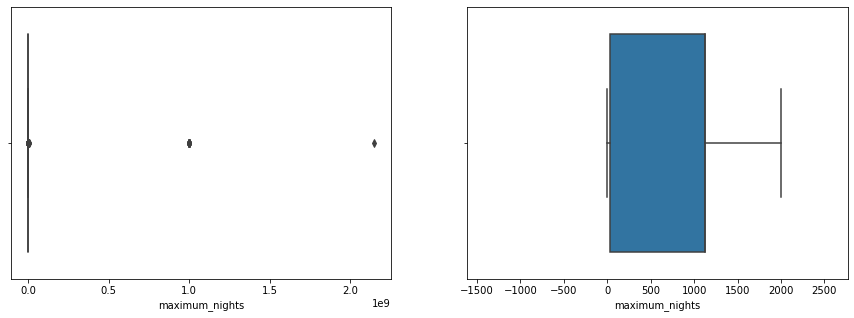

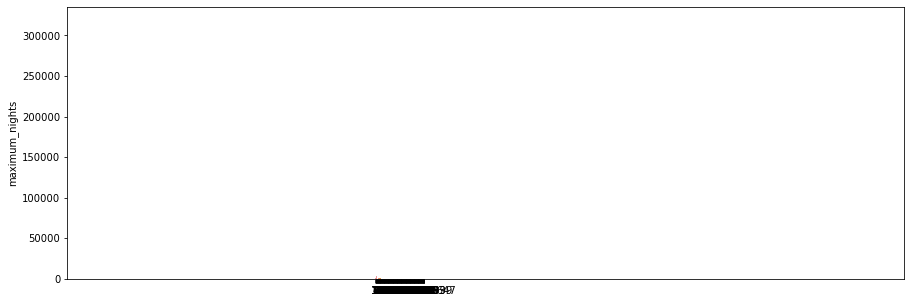

In [222]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [223]:
#excluir coluna que não servirar para analise
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews    

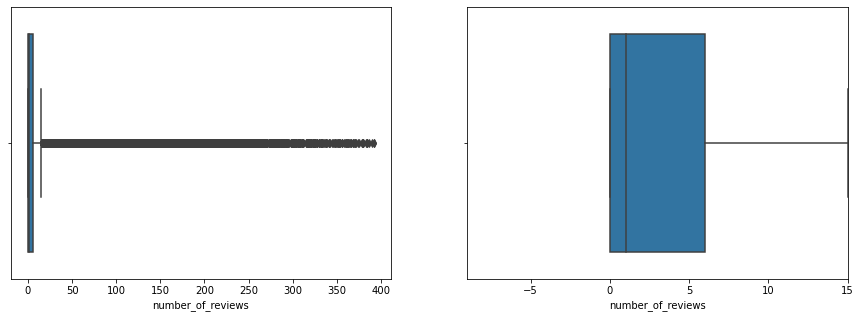

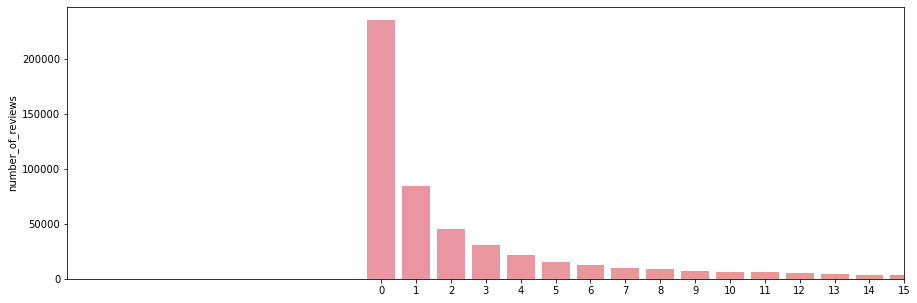

In [224]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [225]:
#excluir coluna que review não vai ajudar a metrica para um novo imovel, pois não tem dados de reviews
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de coluna de valores de texto

* property_type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


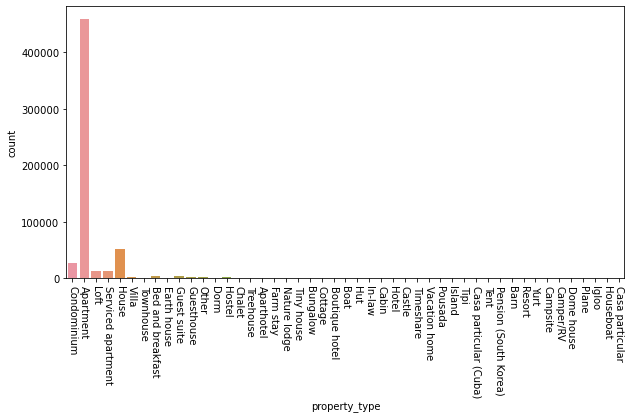

In [226]:
print(base_airbnb['property_type'].value_counts())

plt.figure(figsize=(10,5))
grafico = sms.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=-90)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


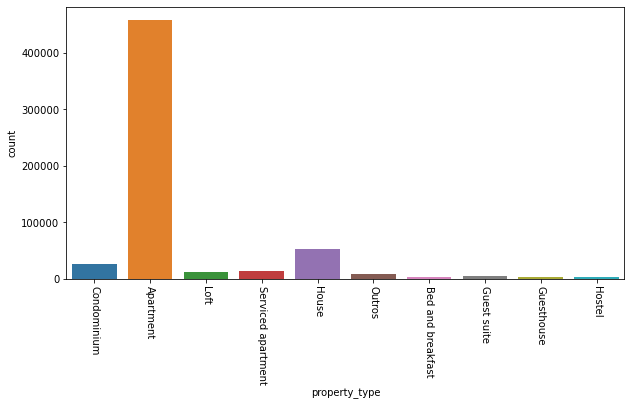

In [227]:
tabelo_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

#criar uma lista com os tipos com valores abaixo de 2000
for tipo in tabelo_tipos_casa.index:
    if tabelo_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
        
        
print(colunas_agrupar)


#para cada intem/tipo  da lista colunas_agrupar que for acima de 200, alterar nome para 'Outros'
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros' 

    
print(base_airbnb['property_type'].value_counts())


plt.figure(figsize=(10,5))
grafico = sms.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=-90)

### * room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


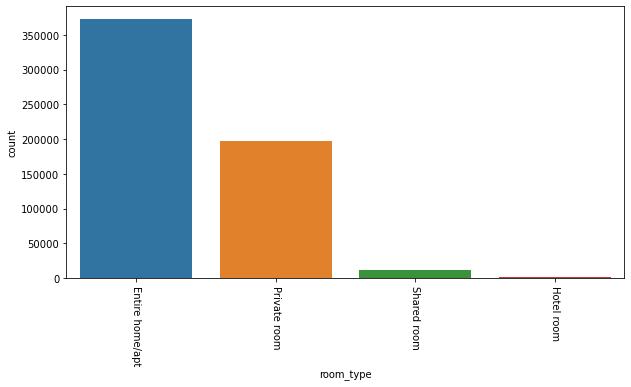

In [228]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(10,5))
grafico = sms.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=-90)



- bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


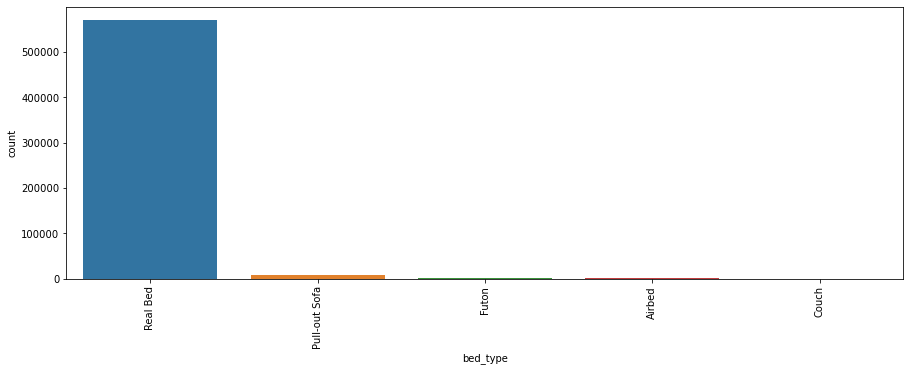

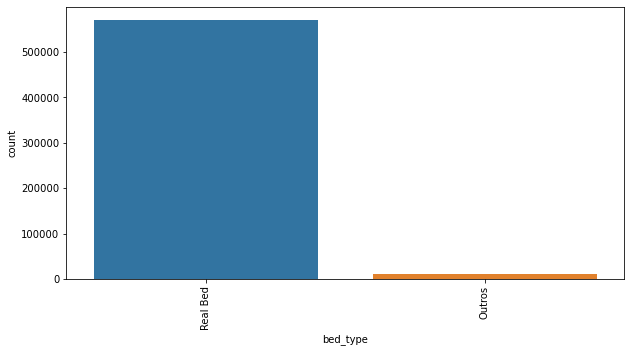

In [229]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15,5))
grafico = sms.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)


#Agrupando categorias  de bed_type 
tabelo_bed = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

#criar uma lista com os tipos com valores abaixo de 2000
for tipo in tabelo_bed.index:
    if tabelo_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)        
print(colunas_agrupar)

#para cada intem/tipo  da lista colunas_agrupar que for acima de 200, alterar nome para 'Outros'
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros' 
   
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(10,5))
grafico = sms.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)




- amenities

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


C:\Users\gleisson.santos\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


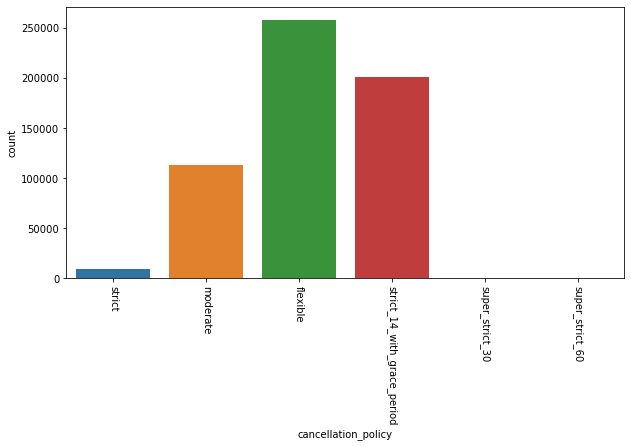

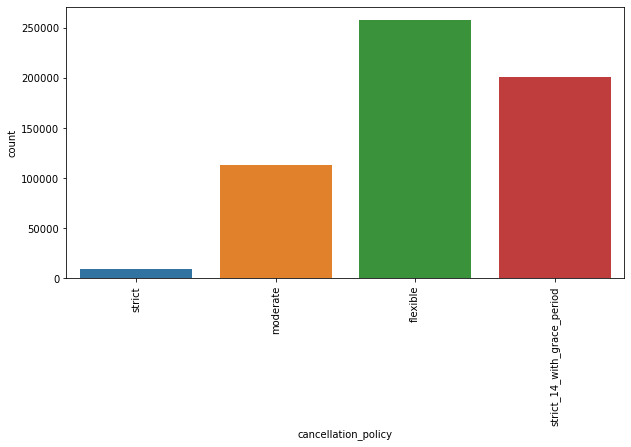

In [230]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(10,5))
grafico = sms.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=-90)

#Agrupando categorias com menores valores 'Super Strict
tabelo_cancellation = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

#criar uma lista com os tipos com valores abaixo de 2000
for tipo in tabelo_cancellation.index:
    if tabelo_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)        
print(colunas_agrupar)

#para cada intem/tipo  da lista colunas_agrupar que for acima de 200, alterar nome para 'Outros'
for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict' 
   
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(10,5))
grafico = sms.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)


 - amenities
 
 Como tempos uma diversidade grande de amenitiesc, e algumas vezes posuem a escrita diferte, vamos analisar a quantidade de amenities como parametro para o nosso modelo

In [231]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [232]:
#excluir coluna que não servirar para analise
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape             
                       


(581983, 20)

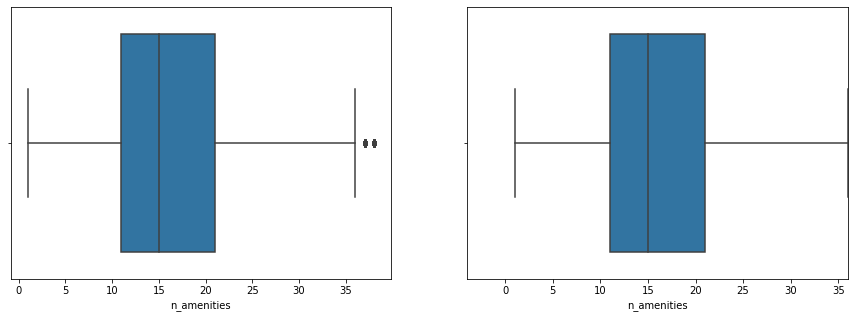

In [240]:
#Qtd de imoveis a pessoa tem
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [241]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

6566 linhas removidas


### Visualização de Mapa das Propriedades

In [266]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                         center=centro_mapa, zoom=10,
                         mapbox_style='stamen-terrain')

mapa.show()

### Encoding

Necessario ajustar as features para faciliar o trabalho do modelo(True ou False

* Features de valores True ou False, faremos a troca de True por 1 e False por 0.

* Features de categoria (features em que os valores da coluna são textos) estaremos utilizando o metodo de encoding de valores dummies

### Visualização de Mapas das Prorpriedades

In [267]:
colunas_tf = ['host_is_superhost','instant_bookable','is_business_travel_ready'  ]
#print(base_airbnb.columns)


Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'extra_people', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'ano', 'mes', 'n_amenities'],
      dtype='object')


In [272]:
colunas_tf = ['host_is_superhost','instant_bookable','is_business_travel_ready'  ]
#print(base_airbnb.columns)

base_airbnb_cod = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 't', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna] == 'f', coluna] = 0

print(base_airbnb_cod.iloc[0])

host_is_superhost                         1
host_listings_count                     2.0
latitude                         -22.965919
longitude                        -43.178962
property_type                   Condominium
room_type                   Entire home/apt
accommodates                              5
bathrooms                               1.0
bedrooms                                2.0
beds                                    2.0
bed_type                           Real Bed
price                                 270.0
extra_people                           51.0
minimum_nights                            4
instant_bookable                          1
is_business_travel_ready                  0
cancellation_policy                  strict
ano                                    2018
mes                                       4
n_amenities                              25
Name: 1, dtype: object


In [273]:
colunas_categorias = ['property_type','room_type','bed_type','cancellation_policy'  ]
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)

display(base_airbnb_cod.head())

host_is_superhost  host_listings_count   latitude  longitude  accommodates  \
1                 1                  2.0 -22.965919 -43.178962             5   
3                 0                  3.0 -22.977117 -43.190454             3   
4                 1                  1.0 -22.983024 -43.214270             3   
5                 1                  1.0 -22.988165 -43.193588             3   
6                 1                  1.0 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros  bed_type_Real Bed  \
1                      0                0                  1   
3                      0                0                  1   
4                      0                0                  1   
5                      0                0                  1   
6                      0                0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo

('Esqueci a senha', {2: '', 3: ''})
